## Summary

1. Overview
2. Dependecies and parameters
3. Data import
4. Quality check
5. The model
    - Data pre-processing
    - Model development
    - Performance evaluation
4. Prediction on unlabelled data
5. Model saving

# 1. Overview

In scope of predict the default probabilty for a given account, given several predictors, I built a sequential Neural Network.

At a first look, the input data contains a lot of NULL values, so they have to be taken into account in the model, I cannot just remove them.

To develop the NN I used Keras framework, based on Tensorflow. Many predictors are categorical, so I had to encode them with one-hot key method to fit the expected format. Moreover, to be able to correctly encode future new data and make predictions on them, I had to save the categories.

The Net has a initial masking layer, to take into account the NULL values mentioned before. I tuned the hyperparametes (mainly number of layers, number of neurons and optimizer) to improve the performance as much as possible. Accuracy is not a good indicator of the goodness of the model, because the 2 classes (Default=TRUE and Default=FALSE) are very unbalanced, so a dummy model that predicts always Default=FALSE has a good accuracy. For this reason, I used the metrics Precision and Recall as goodness indicator. For the same reason, I added weights based on the class numerosity to the fit function.

No regularizer has been out in place.

Finally, I made predicton on unlabelled data.

The model and the list of predictors are saved directly in the folder used to build the Docker image.

# 2. Dependecies and parameters

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from keras.utils import to_categorical
from keras import models, layers, regularizers, metrics, optimizers

In [2]:
data_folder_path='./../data/'
model_folder_path='./../lambda_default_predictor/trained_model/'

input_file_name = 'dataset.csv'
output_file_name = 'predictions.csv'

In [3]:
test_size = 20000

# 3. Data import

In [4]:
input_df = pd.read_csv(data_folder_path+input_file_name, sep=';')

In [5]:
input_df.head(2)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN


In [6]:
unlabelled_df = input_df[input_df.default.isna()]

In [7]:
df = input_df[input_df.default.notna()]

In [8]:
input_df.shape, unlabelled_df.shape, df.shape

((99976, 43), (10000, 43), (89976, 43))

In [9]:
numerics_columns = ['account_amount_added_12_24m',
       'account_days_in_dc_12_24m', 'account_days_in_rem_12_24m',
       'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'age', 'avg_payment_span_0_12m',
       'avg_payment_span_0_3m',
       'has_paid', 'max_paid_inv_0_12m', 'max_paid_inv_0_24m',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_dc_12_24m', 'num_arch_ok_0_12m',
       'num_arch_ok_12_24m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m',
       'num_unpaid_bills', 'recovery_debt',
       'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m',
       'sum_paid_inv_0_12m', 'time_hours']
categorical_columns = ['account_status', 'account_worst_status_0_3m',
       'account_worst_status_12_24m', 'account_worst_status_3_6m',
       'account_worst_status_6_12m', 'merchant_category', 'merchant_group','name_in_email',
                       'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 'status_max_archived_0_12_months',
       'status_max_archived_0_24_months', 'worst_status_active_inv']

# 4. Quality check

Very unbalances classes:

In [10]:
df.groupby('default').default.count()

default
0.0    88688
1.0     1288
Name: default, dtype: int64

A lot of NULL values for some columns:

In [11]:
pd.DataFrame(df.isna().sum(axis=0)/df.shape[0])

,0
uuid,0.000000
default,0.000000
account_amount_added_12_24m,0.000000
account_days_in_dc_12_24m,0.118732
account_days_in_rem_12_24m,0.118732
account_days_in_term_12_24m,0.118732
account_incoming_debt_vs_paid_0_24m,0.593014
account_status,0.543856
account_worst_status_0_3m,0.543856
account_worst_status_12_24m,0.667456


# 5. The model

## 5.1 Data pre-processing

In [12]:
df = df.fillna(-1)

In [13]:
df_numerics = df[numerics_columns]
df_categorical = df[categorical_columns]

In [14]:
df_numerics.shape, df_categorical.shape

((89976, 26), (89976, 15))

In [15]:
one_hot_list=[]
categories_dict = {}
for col_name in df_categorical:
    col = df_categorical[col_name]
    categories = list(col.unique())
    labels = col.apply(lambda x: categories.index(x)).tolist()
    one_hot_list.append(to_categorical(labels))
    categories_dict.update({col_name:categories})

In [16]:
one_hot= np.concatenate(one_hot_list, axis=1)

In [17]:
np.shape(one_hot)

(89976, 135)

In [18]:
X = np.concatenate([df_numerics.values, one_hot], axis=1)

In [19]:
np.shape(X)

(89976, 161)

## 5.2 Model development

In [20]:
y = df['default'].to_numpy()

In [21]:
y = y.reshape(len(y),1)

In [22]:
np.shape(y)

(89976, 1)

In [23]:
X_train = X[:-test_size].astype('float32')
y_train = y[:-test_size]

In [24]:
np.shape(y_train)

(69976, 1)

In [25]:
X_test = X[-test_size:].astype('float32')
y_test = y[-test_size:]

In [26]:
l1_l2 = 1e-4

In [27]:
model = models.Sequential()
model.add(layers.Masking(mask_value=-1,input_shape=(np.shape(X)[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2021-10-13 20:53:37.513679: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-13 20:53:37.513856: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 20:53:37.514667: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [28]:
metrics_list = [
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name="precision"),
    metrics.Recall(name="recall")
]

In [29]:
opt = optimizers.RMSprop(learning_rate=0.001)

In [30]:
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=metrics_list)

In [31]:
counts = df.groupby('default').default.count().to_numpy()

In [32]:
weight_for_0 = (1.0 / counts[0])
weight_for_1 = (1.0 / counts[1])

In [33]:
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=512,
                    validation_split=0.1,
                   class_weight = {0: weight_for_0, 1: weight_for_1})

2021-10-13 20:53:37.730414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-13 20:53:37.748618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/50
124/124 [==============================] - 4s 20ms/step - loss: 0.0071 - accuracy: 0.6782 - precision: 0.0204 - recall: 0.4630 - val_loss: 2.6023 - val_accuracy: 0.9245 - val_precision: 0.0495 - val_recall: 0.2110
Epoch 2/50
124/124 [==============================] - 1s 12ms/step - loss: 7.7443e-04 - accuracy: 0.6525 - precision: 0.0225 - recall: 0.5377 - val_loss: 1.9853 - val_accuracy: 0.8717 - val_precision: 0.0375 - val_recall: 0.2936
Epoch 3/50
124/124 [==============================] - 1s 10ms/step - loss: 3.5396e-04 - accuracy: 0.6587 - precision: 0.0216 - recall: 0.5153 - val_loss: 2.5632 - val_accuracy: 0.8310 - val_precision: 0.0347 - val_recall: 0.3670
Epoch 4/50
124/124 [==============================] - 1s 11ms/step - loss: 2.2490e-04 - accuracy: 0.6400 - precision: 0.0201 - recall: 0.5052 - val_loss: 7.9741 - val_accuracy: 0.5692 - val_precision: 0.0252 - val_recall: 0.7064
Epoch 5/50
124/124 [==============================] - 2s 12ms/step - loss: 1.6374e-04 - 

## 5.3 Performance evaluation

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

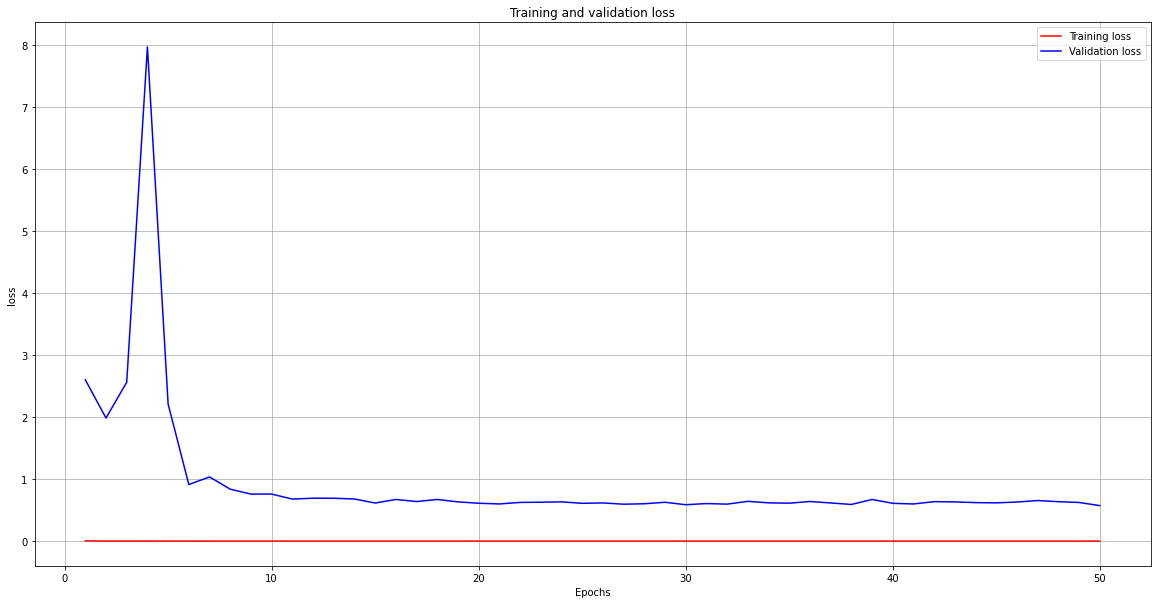

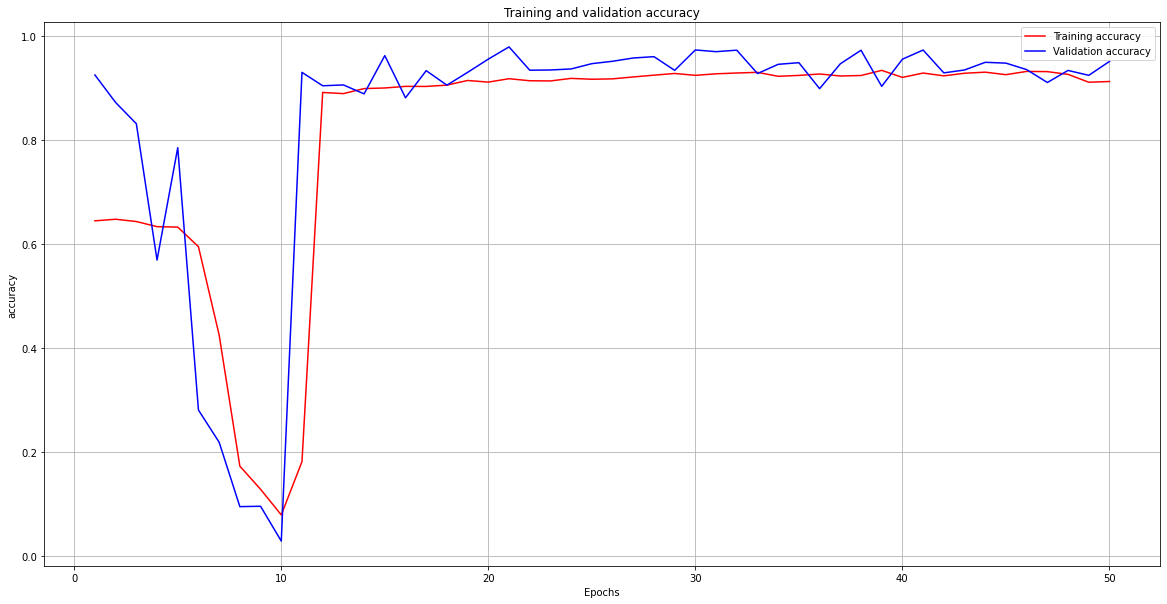

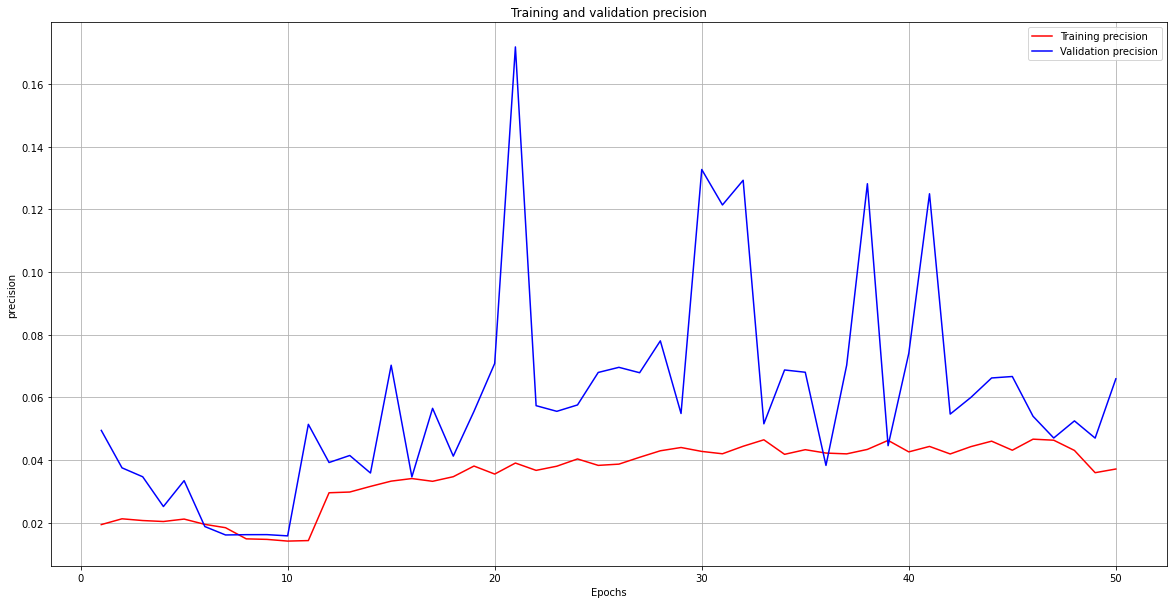

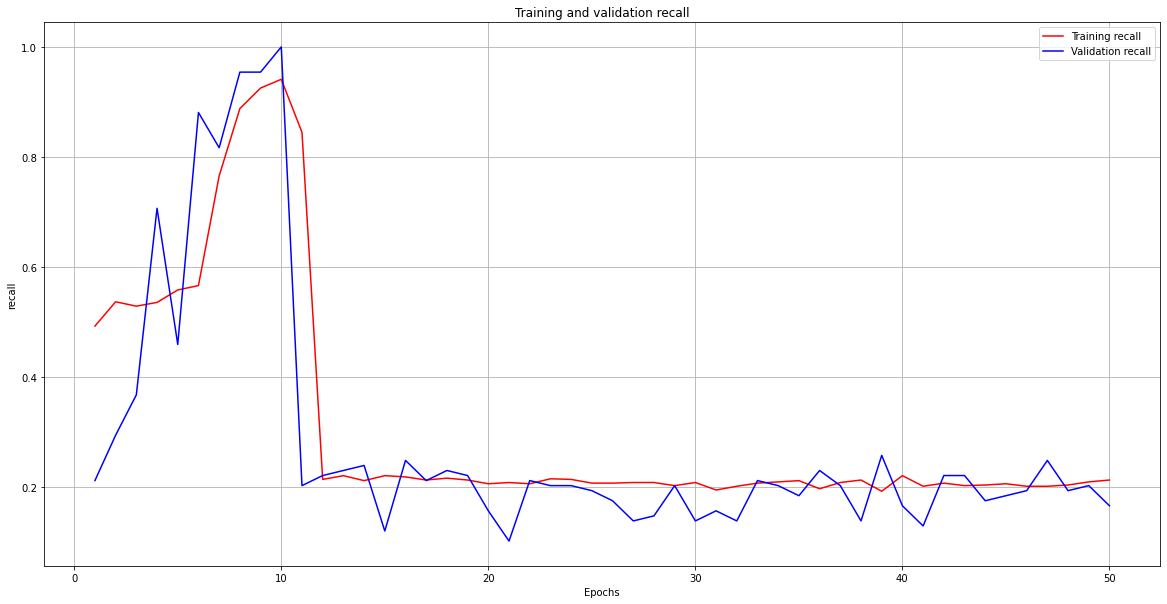

In [35]:
for met in list(history.history.keys())[:4]:
    training_metric = history.history[met]
    validation_metric = history.history['val_'+met]

    epochs = range(1, len(training_metric) + 1)

    plt.figure(figsize=(20,10))
    plt.grid()
    plt.plot(epochs, training_metric, 'red', label='Training '+met)
    plt.plot(epochs, validation_metric, 'blue', label='Validation ' +met)
    plt.title('Training and validation ' + met)
    plt.xlabel('Epochs')
    plt.ylabel(met)
    plt.legend()

    plt.show()

In [36]:
model.evaluate(X_test, y_test);

625/625 [==============================] - 3s 3ms/step - loss: 0.5689 - accuracy: 0.9545 - precision: 0.0665 - recall: 0.1582


# 6. Prediction on unlabelled data

In [37]:
unlabelled_df.head(2)

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
89976,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,NaN,0,0.0,0.0,0.0,0.009135,1.0,1.0,NaN,...,1,1,1,1,0,8815,0,27157,19.895556,NaN
89977,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,NaN,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.236667,NaN


In [38]:
unlabelled_df = unlabelled_df.fillna(-1)

In [39]:
un_df_numerics = unlabelled_df[numerics_columns]
n_rows = unlabelled_df.shape[0]

In [40]:
one_hot_list = []
for key, value in categories_dict.items():
    indexes = unlabelled_df[key].apply(lambda x: value.index(x))
    one_hot = np.zeros((n_rows, len(value)))
    one_hot[range(n_rows), indexes] = 1
    one_hot_list.append(one_hot)

In [41]:
X_pred = np.concatenate([un_df_numerics] + one_hot_list, axis=1).astype('float32')
y_pred = model.predict(X_pred)

In [42]:
unlabelled_df.uuid.reset_index().uuid

0       6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7
1       f6f6d9f3-ef2b-4329-a388-c6a687f27e70
2       e9c39869-1bc5-4375-b627-a2df70b445ea
3       6beb88a3-9641-4381-beb6-c9a208664dd0
4       bb89b735-72fe-42a4-ba06-d63be0f4ca36
                        ...                 
9995    5c03bc63-ea65-4ffd-aa7b-95ea9a46db34
9996    f8db22f4-9819-420c-abbc-9ddf1843176e
9997    b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8
9998    bafcab15-9898-479c-b729-c9dda7edb78f
9999    ac88f18c-96a6-49bc-9e9d-a780225914af
Name: uuid, Length: 10000, dtype: object

In [43]:
predictions = pd.DataFrame(dict(
    uuid =unlabelled_df.uuid.reset_index().uuid,
    pr = pd.DataFrame(y_pred, columns=['pr']).reset_index().pr
))

In [44]:
predictions.head(5)

,uuid,pr
0,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.466145
1,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.086848
2,e9c39869-1bc5-4375-b627-a2df70b445ea,0.466145
3,6beb88a3-9641-4381-beb6-c9a208664dd0,0.466145
4,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.466145


In [45]:
predictions.to_csv(data_folder_path+output_file_name, sep=';', index=False)

# 7. Model saving

In [46]:
model.save(model_folder_path+'model.h5')

In [47]:
with open(model_folder_path+'categories.txt', "wb") as fp:
    pickle.dump(categories_dict, fp)

In [48]:
with open(model_folder_path+'numerics_columns.txt', "wb") as fp:
    pickle.dump(list(set(numerics_columns) & set(df.columns)), fp)